# Music Machine Learning - Bayesian inference

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. An introduction to [Bayesian inference](#bayesian)
2. A formal introduction to [Variational Auto-Encoders](#vae) (VAEs)
3. An explanation of the [implementation](#implem) of VAEs
4. Some [modifications and tips to improve the reconstruction](#improve) of VAEs **(exercise)**

<a id="recap"> </a>

## Introduction on Bayesian inference

Here, we discuss *Bayesian inference* and how to use the **Bayes theorem** to perform classification. First, we will see how to derive *estimators* for the different properties of the distributions, and verify that these are *unbiased*. Then, we will implement the **Maximum Likelihood** Estimators (MLE) in order to perform classification of a dataset. First, we will assess the case where parameters are known to implement the discriminant function and decision rule. Then, we will perform the MLE to obtain the means and covariance matrix for each class.

To understand these concepts graphically, we will rely on both the `scikit-learn` and `Pytorch` libraries (with the `probability` package).

In [37]:
import torch
import torch.distributions as distribution
import torch.distributions.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style, plot_gaussian_ellipsoid
from scipy.stats import multivariate_normal
hdr_plot_style()

### Bayesian framework

Two alternative interpretations of probability can be considered  

  * **Frequentist** (*classical* approach), assumes that probability is the *long-term frequency of events*. This becomes harder to interpret when events have no long-term frequency (eg. probability in an election, which happens only once). In that case, frequentists consider the *frequency of occurrences across alternative realities*, which defines the probability. 
  * **Bayesian** interprets probability as measure of *believability in an event*. Therefore, a probability is measure of *belief*, or confidence, of an event occurring. This definition leaves room for conflicting beliefs based on the different *information* about the world. Hence, bayesian inference is mostly based on *updating your beliefs* after considering new *evidence*.

To align with probability notation, we denote a belief about event $a$ as $p\left(a\right)$, called the *prior probability* of an event to occur. We denote the updated belief as $ p\left( a \mid e \right) $, interpreted as the probability of $a$ *given* the new evidence $e$, called the *posterior probability*. The prior belief is not completely removed, but we *re-weight this prior* to incorporate new evidence $e$ (i.e. we put more weight, or confidence, on some beliefs versus others). By introducing prior uncertainty about events, we admit that any guess we make can be wrong. As we gather an *infinite* amount of evidence $N \rightarrow \infty$, the Bayesian results (often) align with frequentist results. Hence for small $N$, inference is *unstable*, where frequentist estimates have more variance and larger confidence intervals. However, by introducing a prior, and returning probabilities, we *preserve the uncertainty* that reflects the instability on a small $N$ dataset.  

Updating the *prior belief* to obtain our *posterior belief* is done via the the Bayes' Theorem

$$
\begin{equation}
 p\left( a \mid e \right) \propto \frac{ p\left(e \mid a\right) p\left(a\right) } {p\left(e\right) }
\end{equation}
$$

We see that our posterior belief of event $a$ given the new evidence $e$ is proportional to ($\propto$) the *likelihood* of observing this particular evidence $e$ given the event $a$ ($p\left(e \mid a\right)$) multiplied by our prior belief in that particular event $a$ ($p\left(a\right)$).

### Using Bayesian classification (in `scikit-learn`)

The Bayesian classification methods rely on Bayes's theorem, where we are interested in finding the probability of a label $y$ given some observed features, which we can write as $p(y~|~{\rm features})$. Bayes's theorem tells us how to express this in terms of quantities that we can compute more directly

$$
p(y~|~{\rm features}) = \frac{p({\rm features}~|~y)p(y)}{p({\rm features})}
$$

If we are trying to decide between two labels ($y_1$ and $y_2$), then one way to make this decision is to compute the ratio of the posterior probabilities for each label

$$
\frac{p(y_1~|~{\rm features})}{p(y_2~|~{\rm features})} = \frac{p({\rm features}~|~y_1)}{p({\rm features}~|~y_2)}\frac{p(y_1)}{p(y_2)}
$$

All we need now is some model by which we can compute $p({\rm features}~|~y_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model. If we make *very naive assumptions* (called *Naive Bayes*) about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.

#### Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*. Imagine that we have the following data

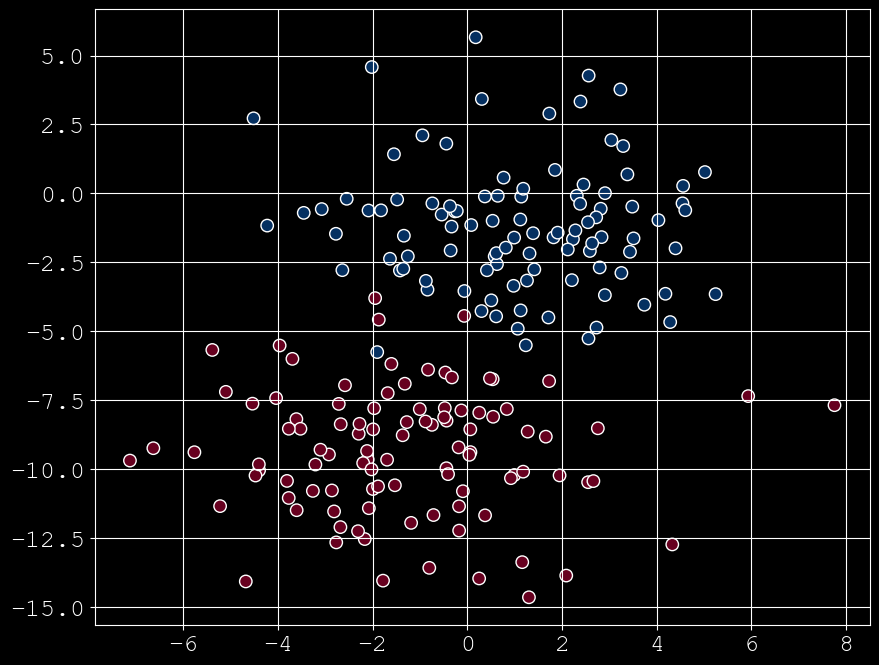

In [38]:
hdr_plot_style()
from sklearn.datasets import make_blobs
X, y = make_blobs(200, 2, centers=2, random_state=2, cluster_std=2.2)
plt.figure(figsize=(10, 8)); plt.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap='RdBu', edgecolor='w'); plt.grid(True)

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.

With this generative model for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point. This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator

In [39]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)

GaussianNB()

Now let's generate some new data and predict the label:

In [40]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot the data and see where the decision boundary is

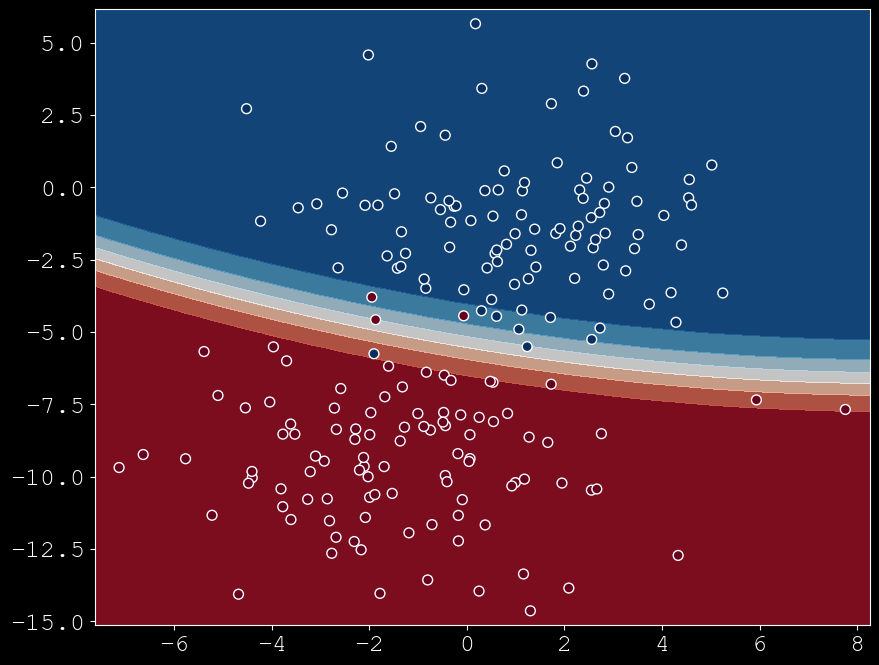

In [41]:
fig = plt.figure(figsize=(10,8)); ax = fig.add_subplot(111)
# predict the classification probabilities on a grid
xlim = X[:, 0].min() - .5, X[:, 0].max() + .5
ylim = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu', edgecolor='w')
plt.show()

We see a slightly curved boundary in the classifications (generally, the boundary in Gaussian naive Bayes is quadratic). A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [42]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.9 , 0.1 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.95, 0.05]])

The columns give the posterior probabilities of the first and second label, respectively. If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach. Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.

## Bayesian inference

Suppose we have coin and want to estimate the probability of heads ($p$) for it. The coin is Bernoulli distributed:

$$ 
\begin{equation}
\phi(x)= p^x (1-p)^{(1-x)} 
\end{equation}
$$

where $x$ is the outcome, *1* for heads and *0* for tails. Based on $n$ *independent* flips, we have the likelihood:

$$ 
\begin{equation}
\mathcal{L}(p|\mathbf{x})= \prod_{i=1}^n p^{ x_i }(1-p)^{1-x_i} 
\end{equation}
$$

(the independent-trials assumption allows us to just substitute everything into $ \phi(x)$). 

The idea of *maximum likelihood* will be to maximize this as the function of $p$ after given all of the $x_i$ data. This means that our estimator, $\hat{p}$, is a function of the observed $x_i$ data, and as such, is a random variable with its own distribution.

**Defining the estimator**

The only way to know for sure that our estimator is correctly defined is to check if the estimator is unbiased, namely, if

$$ \mathbb{E}(\hat{p}) = p $$


### Understanding this behavior with `pytorch`

Without solving for the previous exercise, we can  Let's say that we have 100 samples from a Bernoulli distribution.

tensor(0.6990)

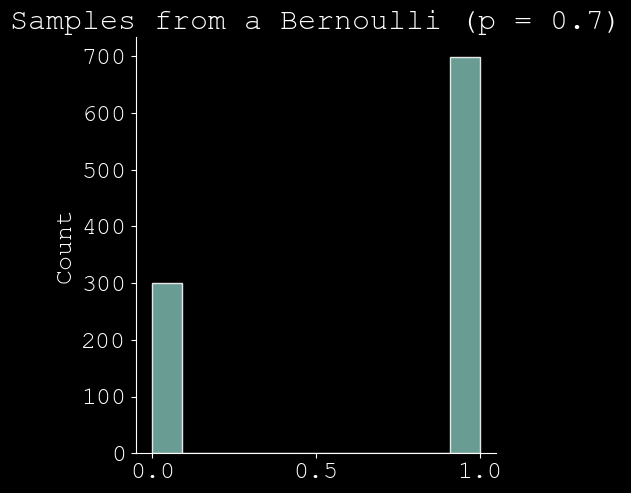

In [43]:
p = 0.7
bernoulli = distribution.Bernoulli(p)
sample = bernoulli.sample((1000, ))
sns.displot(sample)
plt.title(f"Samples from a Bernoulli (p = {p})")
torch.mean(sample)

Now we can use our estimator, and define our problem more formally, by defining our input samples as a dataset of observations $x$, and we are trying to model this set, as a `Bernoulli` distribution, for which the $p$ parameter is unknown (here defined as a `Variable`).

In [44]:
from torch.autograd import Variable
x = Variable(sample).type(torch.FloatTensor)
p = Variable(torch.rand(1), requires_grad=True)

Now we can use our estimator to gradually compute the Maximum Likelihood, in order to uncover the estimated probability of the underlying distribution, solely based on observing the samples.

In [45]:
learning_rate = 0.00002
for t in range(1000):
    NLL = -torch.sum(torch.log(x*p + (1-x)*(1-p)) )
    NLL.backward()
    if t % 200 == 0:
        print("loglik = %.4f - p = %.4f - dL/dp = %.4f"%(NLL.data.numpy(), p.data.numpy(), p.grad.data.numpy()))   
    p.data -= learning_rate * p.grad.data
    p.grad.data.zero_()
print('Final probability p =', p.data[0])

loglik = 1811.2949 - p = 0.0776 - dL/dp = -8684.1729
loglik = 611.7093 - p = 0.6990 - dL/dp = -0.0013
loglik = 611.7093 - p = 0.6990 - dL/dp = -0.0013
loglik = 611.7093 - p = 0.6990 - dL/dp = -0.0013
loglik = 611.7093 - p = 0.6990 - dL/dp = -0.0013
Final probability p = tensor(0.6990)


***

**Exercise**

  1. Compute the *log-likelihood* $J=\log(\mathcal{L}(p \mid \mathbf{x}))$ of our given problem
  2. Based on this, compute its derivative $ \frac{dJ}{dp} $
  3. Solve it to find the estimator $\hat{p}$
  4. Verify that this estimator is unbiased $ \mathbb{E}(\hat{p}) = p $
  5. Compute the variance of the estimator $ \mathbb{E}\left(\hat{p}^2\right) $

***

\begin{align*}
\mathcal{L}(p|x) &= \prod_{i=1}^{n} p^{x_i}(1-p)^{x_i}\\
log(\mathcal{L}(p|x)) &= \sum_{i=1}^{n} log(p^{x_i}(1-p)^{x_i})\\
&=n\log(1-p)+\log\left(\frac{p}{1-p}\right)\sum_{i=1}^{n}x_i\\
\frac{\partial \mathcal{L}}{\partial p} &= \frac{n\cdot p -\sum_{i=1}^{n}x_i}{p(p-1)}\\
\frac{\partial \mathcal{L}}{\partial p} = 0 &\Leftrightarrow p = \frac{1}{n}\sum_{i=1}^{n}x_i
\end{align*}

In [46]:
x = Variable(sample).type(torch.FloatTensor)
p = torch.rand(1)

p_hat = np.sum(x.numpy())/len(x)
print(p_hat)


0.699


### Full estimator density

In general, computing the mean and variance of the estimator is insufficient to characterize the underlying probability density of $\hat{p}$, except if we knew that $\hat{p}$ were normally distributed. This is where the [*central limit theorem*](http://mathworld.wolfram.com/CentralLimitTheorem.html). Indeed, the form of the estimator, implies that $\hat{p}$ is normally distributed, but only *asymptotically*, which doesn't quantify how many samples $n$ we need. Unfortunately, in the real world, each sample may be precious. Hence, to write out the full density for $\hat{p}$, we first have to ask what is the probability that the estimator will equal a specific value such as

$$  
\begin{equation}
\hat{p} = \frac{1}{n}\sum_{i=1}^n x_i  = 0 
\end{equation}
$$

This can only happen when $x_i=0$,  $\forall i$. The corresponding probability can be computed from the density

$$ 
\begin{equation}
f(\mathbf{x},p)= \prod_{i=1}^n \left(p^{x_i} (1-p)^{1-x_i}  \right) 
\end{equation}
$$

$$ 
\begin{equation}
f\left(\sum_{i=1}^n x_i  = 0,p\right)= \left(1-p\right)^n  
\end{equation}
$$

Likewise, if $\lbrace x_i \rbrace$ has one $i^{th}$ value equal to one, then

$$ 
\begin{equation}
f\left(\sum_{i=1}^n x_i  = 1,p\right)= n p \prod_{i=1}^{n-1} \left(1-p\right)
\end{equation}
$$

where the $n$ comes from the $n$ ways to pick one value equal to one from the $n$ elements $x_i$. Continuing this way, we can construct the entire density as

$$
\begin{equation}
f\left(\sum_{i=1}^n x_i  = k,p\right)= \binom{n}{k} p^k  (1-p)^{n-k}  
\end{equation}
$$

where the term on the left is the binomial coefficient of $n$ things taken $k$ at a time. This is the binomial distribution and it's not the density for $\hat{p}$, but rather for $n\hat{p}$. We'll leave this as-is because it's easier to work with below. We just have to remember to keep track of the $n$ factor.

## Maximum Likelihood implementation

Maximum Likelihood Estimate (MLE) allows to perform typical statistical pattern classification tasks. In the cases where **probabilistic models and parameters are known**, the design of a Bayes' classifier is rather easy. However, in real applications, we are rarely given this information and this is where the MLE comes into play.

MLE still **requires partial knowledge** about the problem. We have to assume that the **model of the class conditional densities is known** (usually Gaussian distributions). Hence, Using MLE, we want to estimate the values of the parameters of a given distribution for the class-conditional densities, for example, the *mean* and *variance* assuming that the class-conditional densities are *normal*  distributed (Gaussian) with 

$$
\begin{equation}
p(\pmb x   \mid   y_i) \sim N(\mu, \sigma^2)
\end{equation}
$$

### Parameters known

Imagine that we want to classify data consisting of two-dimensional patterns, $\pmb{x} = [x_1, x_2] \in \mathbb{R}^{2}$ that could belong to 1 out of 3 classes $y_1,y_2,y_3$. 

Let's assume the following information about the model where we use continuous univariate normal (Gaussian) model for the class-conditional densities


$$ 
\begin{equation}
p(\pmb x \mid y_j) \sim N(\pmb \mu \mid \Sigma) = \frac{1}{(2\pi)^{d/2}   \mid \Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]
\end{equation}
$$

Furthermore, we consider for this first problem that we know the distributions of the classes, ie. their mean and covariances.

$$
\begin{equation}
p([x_1, x_2]^t \mid y_1) ∼ N([0,0],3I), \\
p([x_1, x_2]^t \mid y_2) ∼ N([9,0],3I), \\
p([x_1, x_2]^t \mid y_3) ∼ N([6,6],4I),
\end{equation}
$$

Therefore, the means of the sample distributions for 2-dimensional features are defined as  

$$ 
\begin{equation}
\pmb{\mu}_{\,1} = \bigg[ 0, 0 \bigg],    \pmb{\mu}_{\,2} = \bigg[ 9,  0 \bigg],    \pmb{\mu}_{\,3} = \bigg[ 6,  6 \bigg] 
\end{equation}
$$

The **covariance matrices** for the statistically independent and identically distributed ('i.i.d') features

$$ 
\begin{array}{ccc}
\Sigma_1 = \bigg[ 
\begin{array}{cc}
3 & 0\\
0 & 3 \\
\end{array} \bigg], 
\Sigma_2 = \bigg[ 
\begin{array}{cc}
3 & 0\\
0 & 3 \\
\end{array} \bigg], 
\Sigma_3 = \bigg[ 
\begin{array}{cc}
4 & 0\\
0 & 4 \\
\end{array} \bigg] 
\end{array}$$

Finally, we consider that all classes have an **equal prior probability**  

$$p(y_1)   =    p(y_2)   =   p(y_3)   = \frac{1}{3}$$


***

**Exercise**

  1. Generate some data (samples from the multivariate Gaussians) following classes distributions
  2. Plot the class-dependent data
  
***

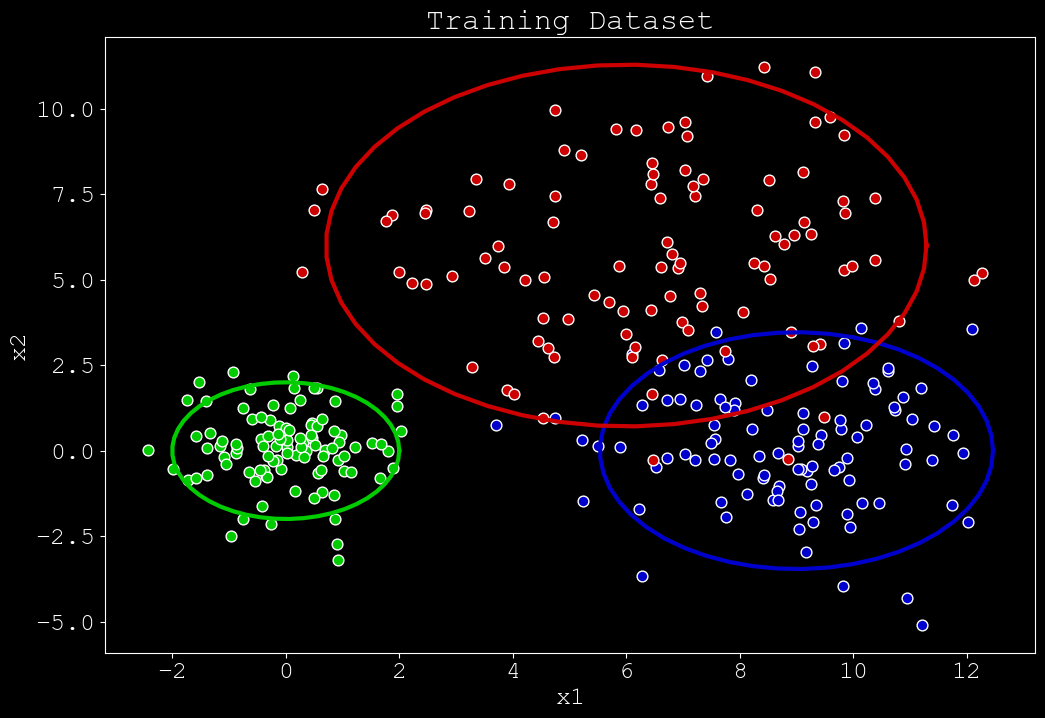

In [47]:
# 7.0 - Generate data with known parameters

nb_patterns = 100
# Generate random patterns for class 1
mu1 = np.array([0, 0])
cov1 = np.array([[1, 0], [0, 1]])
# Generate random patterns for class 2
mu2 = np.array([9, 0])
cov2 = np.array([[3, 0], [0, 3]])
# Generate random patterns for class 3
mu3 = np.array([6, 6])
cov3 = np.array([[7, 0], [0, 7]])

x1samples = multivariate_normal.rvs(mu1, cov1, nb_patterns)
x2samples = multivariate_normal.rvs(mu2, cov2, nb_patterns)
x3samples = multivariate_normal.rvs(mu3, cov3, nb_patterns)


# Prepare concatenated versions of class properties
mu_vals = {}
mu_vals[0] = np.array([mu1]).transpose()
mu_vals[1] = np.array([mu2]).transpose()
mu_vals[2] = np.array([mu3]).transpose()
cov_vals = {}
cov_vals[0] = cov1
cov_vals[1] = cov2
cov_vals[2] = cov3
# Plot the corresponding data
plt.figure(figsize=(12, 8))
plt.scatter(
    x1samples[:, 0], x1samples[:, 1], s=60, marker="o", color=[0, 0.8, 0], edgecolors="w"
)
plt.scatter(
    x2samples[:, 0], x2samples[:, 1], s=60, marker="o", color=[0, 0, 0.8], edgecolors="w"
)
plt.scatter(
    x3samples[:, 0], x3samples[:, 1], s=60, marker="o", color=[0.8, 0, 0], edgecolors="w"
)
h = plot_gaussian_ellipsoid(mu1, cov1, 2, color=[0, 0.8, 0])
h = plot_gaussian_ellipsoid(mu2, cov2, 2, color=[0, 0, 0.8])
h = plot_gaussian_ellipsoid(mu3, cov3, 2, color=[0.8, 0, 0])
plt.title("Training Dataset")
plt.ylabel("x2")
plt.xlabel("x1")
plt.show()

Here, our **objective function** is to maximize the discriminant function $g_i(\pmb x)$, which we define as the posterior probability to perform a **minimum-error classification** (Bayes classifier). 

$$
\begin{equation}
g_1(\pmb x) = p(y_1 \mid   \pmb{x}), \quad  g_2(\pmb{x}) = p(y_2 \mid   \pmb{x}), \quad  g_3(\pmb{x}) = p(y_3 \mid   \pmb{x})
\end{equation}
$$

So that our decision rule is to choose the class $\omega_i$ for which $g_i(\pmb x)$ is max., where  

 $$ 
 \begin{equation}
 \quad g_i(\pmb{x}) = \pmb{x}^{\,t} \bigg( - \frac{1}{2} \Sigma_i^{-1} \bigg) \pmb{x} + \bigg( \Sigma_i^{-1} \pmb{\mu}_{\,i}\bigg)^t \pmb x + \bigg( -\frac{1}{2} \pmb{\mu}_{\,i}^{\,t}  \Sigma_{i}^{-1} \pmb{\mu}_{\,i} -\frac{1}{2} ln(\left|\Sigma_i\right|)\bigg) 
 \end{equation}
 $$

***

**Exercise**

  1. Implement the discriminant function
  2. Implement the decision rule (classifier)
  3. Classify the data generated in the previous exercise
  4. Plot the confusion matrix
  5. Calculate the empirical error

***

In [48]:
import operator


def discriminant_function(x_vec, mu_vec, cov_mat):
    # Calculates the value of the discriminant function for a dx1 dimensional
    # sample given the covariance matrix and mean vector.
    #
    #   x_vec: A dx1 dimensional numpy array representing the sample.
    #   cov_mat: numpy array of the covariance matrix.
    #   mu_vec: dx1 dimensional numpy array of the sample mean.
    #
    #   Returns a float value g as result of the discriminant function.
    inv_cov_mat = np.linalg.inv(cov_mat)

    g = (
        -x_vec.T @ inv_cov_mat @ x_vec / 2
        + (inv_cov_mat @ mu_vec).T @ x_vec
        - (mu_vec.T @ inv_cov_mat @ mu_vec + np.log(np.abs(cov_mat).sum())) / 2
    )

    return float(g)


def classify_data(x_vec, g, mu_vecs, cov_mats):
    #    Classifies an input sample into 1 out of 3 classes determined by
    #    maximizing the discriminant function g_i().

    #    Keyword arguments:
    #        x_vec: A dx1 dimensional numpy array representing the sample.
    #        g: The discriminant function.
    #        mu_vecs: A list of mean vectors as input for g.
    #        cov_mats: A list of covariance matrices as input for g.
    #
    #    Returns the max probability and class id.
    maxVal = -np.inf
    maxId = 0
    for id in range(len(mu_vecs)):
        g_val = g(x_vec, mu_vecs[id], cov_mats[id])
        if g_val > maxVal:
            maxVal = g_val
            maxId = id
    return maxVal, maxId


x1classes = np.zeros((nb_patterns, 1))
conf_matrix = np.zeros((3, 3))
for i in range(nb_patterns):
    x, g = classify_data(x1samples[i, :], discriminant_function, mu_vals, cov_vals)
    x1classes[i] = g
    conf_matrix[0, g] = conf_matrix[0, g] + 1
x2classes = np.zeros((nb_patterns, 1))
for i in range(nb_patterns):
    x, g = classify_data(x2samples[i, :], discriminant_function, mu_vals, cov_vals)
    x2classes[i] = g
    conf_matrix[1, g] = conf_matrix[1, g] + 1
x3classes = np.zeros((nb_patterns, 1))
for i in range(nb_patterns):
    x, g = classify_data(x3samples[i, :], discriminant_function, mu_vals, cov_vals)
    x3classes[i] = g
    conf_matrix[2, g] = conf_matrix[2, g] + 1

print("%16s \t %s \t %s \t %s\n" % (" ", "class 1", "class 2", "class 3"))
print(
    "%16s \t %f \t %f \t %f\n"
    % ("class 1", conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[0, 2])
)
print(
    "%16s \t %f \t %f \t %f\n"
    % ("class 2", conf_matrix[1, 0], conf_matrix[1, 1], conf_matrix[1, 2])
)
print(
    "%16s \t %f \t %f \t %f\n"
    % ("class 3", conf_matrix[2, 0], conf_matrix[2, 1], conf_matrix[2, 2])
)

                 	 class 1 	 class 2 	 class 3

         class 1 	 100.000000 	 0.000000 	 0.000000

         class 2 	 0.000000 	 91.000000 	 9.000000

         class 3 	 0.000000 	 6.000000 	 94.000000



### Unknown parameters

In contrast to the previous case, let us assume that we only know the number of parameters for the class conditional densities $p (\pmb x \mid  y_i)$, and we want to use a Maximum Likelihood Estimation (MLE) to estimate the quantities of these parameters from the training data.


Given the information about the our model (the data is normal distributed) the 2 parameters to be estimated for each class are $\pmb \mu_i$ and $\pmb \Sigma_i$, which are summarized by the parameter vector 

$$
\begin{equation}
\pmb \theta_i = \bigg[ \begin{array}{c}
\ \theta_{i1} \\
\ \theta_{i2} \\
\end{array} \bigg]=
\bigg[ \begin{array}{c}
\pmb \mu_i \\
\pmb \Sigma_i \\
\end{array} \bigg]
\end{equation}
$$ 

For the Maximum Likelihood Estimate (MLE), we assume that we have a set of samples $D = \left\{ \pmb x_1, \pmb x_2,..., \pmb x_n \right\} $ that are *i.i.d.* (independent and identically distributed, drawn with probability $p(\pmb x \mid   y_i, \pmb \theta_i) )$.  Thus, we can **work with each class separately** and omit the class labels, so that we write the probability density as $p(\pmb x \mid \pmb \theta)$ 

**Likelihood of $ \pmb \theta $**

Thus, the probability of observing $D = \left\{ \pmb x_1, \pmb x_2,..., \pmb x_n \right\} $ is  

$$
\begin{equation}
p(D  \mid    \pmb \theta ) = p(\pmb x_1   \mid   \pmb \theta )  \cdot   p(\pmb x_2   \mid  \pmb \theta )   \cdot  ...    p(\pmb x_n   \mid   \pmb \theta ) = \prod_{k=1}^{n}   p(\pmb x_k \pmb   \mid   \pmb \theta  )
\end{equation}
$$  

Where $p(D  \mid    \pmb  \theta )$ is also called the ***likelihood of $\pmb\ \theta$***

We know that $p([x_1,x_2]^t)  ∼   N(\pmb \mu,\pmb \Sigma) $ (remember that we dropped the class labels, since we are working with every class separately). And the mutlivariate normal density is given as  

$$
\begin{equation}
\quad \quad p(\pmb x) = \frac{1}{(2\pi)^{d/2}   |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]
\end{equation}
$$  

Therefore, we obtain  

$$
\begin{equation}
p(D  \mid    \pmb \theta ) = \prod_{k=1}^{n}   p(\pmb x_k \pmb   \mid   \pmb \theta  ) =  \prod_{k=1}^{n}   \frac{1}{(2\pi)^{d/2}   |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]
\end{equation}
$$
and the log of the multivariate density

$$
\begin{equation}
l(\pmb\theta) =  \sum\limits_{k=1}^{n} - \frac{1}{2}(\pmb x - \pmb \mu)^t \pmb \Sigma^{-1}   (\pmb x - \pmb \mu) - \frac{d}{2}   ln   2\pi - \frac{1}{2}  ln   |\pmb\Sigma|
\end{equation}
$$

In order to obtain the MLE $\boldsymbol{\hat{\theta}}$, we maximize $l (\pmb  \theta)$, which can be done via differentiation  

$$
\begin{equation}
\nabla_{\pmb \theta} \equiv \begin{bmatrix}  
\frac{\partial   }{\partial   \theta_1} \\ 
\frac{\partial   }{\partial   \theta_2}
\end{bmatrix} = \begin{bmatrix} 
\frac{\partial   }{\partial   \pmb \mu} \\ 
\frac{\partial   }{\partial   \pmb \sigma}
\end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
\nabla_{\pmb \theta} l = \sum\limits_{k=1}^n \nabla_{\pmb \theta}  ln  p(\pmb x| \pmb \theta) = 0 
\end{equation}
$$  

***

**Exercise**
<div markdown = "1">

  1. Perform the differentiation for $\frac{\partial   \mathcal{L}}{\partial   \pmb \mu}$ to obtain the estimator of the mean $\hat{\mu}$
  2. Perform the differentiation for $\frac{\partial   \mathcal{L}}{\partial   \pmb \Sigma}$ to obtain the estimator of the covariance matrix $\hat{\Sigma}$
  3. Implement the two estimators as functions based on a set of data
  4. Apply these estimators (MLE) in order to obtain estimated parameters
  5. Re-compute the classification errors on the previous dataset
  
***

$$
\frac{\partial \mathcal{L}}{\partial \mu} = \frac{1}{2}\sum_{k=1}^{n} (\Sigma^{-1} + ^{t}\Sigma^{-1})(x-\mu)
$$

In [49]:
########################################################
# YOUR CODE GOES HERE (Perform mu estimates)
########################################################

# mu_est_1 = ?
# mu_est_2 = ?
# mu_est_3 = ?

print('%16s \t %s \t %s \t %s \t %s \t %s \t %s' % ('', 'mu1_1   ', 'mu1_2  ', 'mu2_1  ', 'mu2_2  ', 'mu3_1  ', 'mu3_2  '))
print('%16s \t %f \t %f \t %f \t %f \t %f \t %f' % ('MLE', mu_est_1[0], mu_est_1[1], mu_est_2[0], mu_est_2[1], mu_est_3[0], mu_est_3[1]))
print('%16s \t %f \t %f \t %f \t %f \t %f \t %f' % ('Truth', mu1[0], mu1[1], mu2[0], mu2[1], mu3[0], mu3[1]));

def mle_covariance(x_samples, mu_est):
    #    Calculates the Maximum Likelihood Estimate for the covariance matrix.
    #    
    #    Keyword Arguments:
    #        x_samples: np.array of the samples for 1 class, n x d dimensional 
    #        mu_est: np.array of the mean MLE, d x 1 dimensional
    #        
    #    Returns the MLE for the covariance matrix as d x d numpy array.
    
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    return cov_est_

cov_est_1 = mle_covariance(x1samples, np.array([mu_est_1]).transpose())
cov_est_2 = mle_covariance(x2samples, np.array([mu_est_2]).transpose())
cov_est_3 = mle_covariance(x3samples, np.array([mu_est_3]).transpose())

print('%16s \t %s \t %s \t %s \t %s \t %s \t %s' % ('', 'cov1_1   ', 'cov1_2  ', 'cov2_1  ', 'cov2_2  ', 'cov3_1  ', 'cov3_2  '))
print('%16s \t %f \t %f \t %f \t %f \t %f \t %f' % ('MLE', cov_est_1[0, 0], cov_est_1[1, 0], cov_est_2[0, 0], cov_est_2[1, 0], cov_est_3[0, 0], cov_est_3[1, 0]))
print('%16s \t %f \t %f \t %f \t %f \t %f \t %f' % ('Truth', cov1[0, 0], cov1[1, 0], cov2[0, 0], cov2[1, 0], cov3[0, 0], cov3[1, 0]))

mu_estimates = {}; 
mu_estimates[0] = np.array([mu_est_1]).transpose()  
mu_estimates[1] = np.array([mu_est_2]).transpose()  
mu_estimates[2] = np.array([mu_est_3]).transpose() 
cov_estimates = {}; 
cov_estimates[0] = cov_est_1 
cov_estimates[1] = cov_est_2
cov_estimates[2] = cov_est_3

# Plot the corresponding data
plt.figure(figsize=(12, 8))
plt.scatter(x1samples[:,0], x1samples[:,1], s=40, marker='o', c=[0, 0.8, 0], edgecolors='w')
plt.scatter(x2samples[:,0], x2samples[:,1], s=40, marker='s', c=[0, 0, 0.8], edgecolors='w')
plt.scatter(x3samples[:,0], x3samples[:,1], s=40, marker='^', c=[0.8, 0, 0], edgecolors='w')
h = plot_gaussian_ellipsoid(mu1, cov1, 2, color=[0.2, 0.6, 0.2])
h = plot_gaussian_ellipsoid(mu2, cov2, 2, color=[0.2, 0.2, 0.6])
h = plot_gaussian_ellipsoid(mu3, cov3, 2, color=[0.6, 0.2, 0.2])
h = plot_gaussian_ellipsoid(mu_est_1, cov_est_1, 2, color=[0.1, 0.99, 0.1])
h = plot_gaussian_ellipsoid(mu_est_2, cov_est_2, 2, color=[0.1, 0.1, 0.99])
h = plot_gaussian_ellipsoid(mu_est_3, cov_est_3, 2, color=[0.99, 0.1, 0.1])
plt.title('Comparing estimated MLE Gaussians')

                 	 mu1_1    	 mu1_2   	 mu2_1   	 mu2_2   	 mu3_1   	 mu3_2  


NameError: name 'mu_est_1' is not defined

## Audio source separation

The maximum likelihood estimator (MLE) is widely used in practical signal modeling and we can show that the MLE is equivalent to the least squares estimator for a wide class of problems, including well resolved sinusoids in white noise. We are going to consider a model consisting of a complex sinusoid in additive white (complex) noise:

$$
\displaystyle x(n) = {\cal A}e^{j\omega_{0} n} + v(n)
$$

Here, $ {\cal A}= A e^{j\phi} $ is the complex amplitude of the sinusoid, and $ v(n) $ is white noise that we assume to be Gaussian distributed with zero mean. Hence, we assume that its probability density function is given by  

$$
\displaystyle p_{v}(\nu) = \frac{1}{\pi \sigma_{v}^2} e^{-\frac{\vert\nu\vert^2}{\sigma_{v}^2}}.
$$

We express the zero-mean Gaussian assumption by writing

$$
\displaystyle v(n) \sim {\cal N}(0,\sigma_{v}^2)
$$

The parameter  $ \sigma_{v}^2 $ is the *variance* of the random process $ v(n) $ , and $ \sigma_{v} $ is its standard deviation. It turns out that when Gaussian random variables $ v(n) $ are uncorrelated (i.e., when $ v(n) $ is white noise), they are also independent. This means that the probability of observing particular values of $ v(n) $ and $ v(m) $ is given by the product of their respective probabilities. We will now use this fact to compute an explicit probability for observing any data sequence $ x(n) $

Since the sinusoidal part of our signal model,  $ {\cal A}e^{j\omega_{0}n}$ , is deterministic; i.e., it does not including any random components; it may be treated as the time-varying mean of a Gaussian random process $ x(n) $ . That is, our signal model can be rewritten as

$$
\displaystyle x(n) \sim {\cal N}({\cal A}e^{j\omega_{0} n},\sigma_{v}^2)
$$

and the probability density function for the whole set of observations $ x(n) $ ,  $ n=0,1,2,\ldots,N-1 $ is given by

$$
\displaystyle p(x) = p[x(0)] p[x(1)]\cdots p[x(N-1)] = \left(\frac{1}{\pi \sigma_v^2}\right)^N e^{-\frac{1}{\sigma_v^2}\sum_{n=0}^{N-1} \left\vert x(n) - {\cal A}e^{j\omega_0 n}\right\vert^2}
$$

Thus, given the noise variance  $ \sigma_v^2 $ and the three sinusoidal parameters $ A,\phi,\omega_0 $ (remember that $ {\cal A}= A e^{j\phi} $ ), we can compute the relative probability of any observed data samples $ x(n) $ .

We can generalize this approach in order to perform a complete blind audio source separation algorithm, such as detailed in the following paper   

Févotte, C., & Cardoso, J. F. "Maximum likelihood approach for blind audio source separation using time-frequency Gaussian source models". *IEEE Workshop on Applications of Signal Processing to Audio and Acoustics*, 2005. (pp. 78-81). IEEE.  

You can try to implement this by relying on the [full paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.640.6981&rep=rep1&type=pdf) that details this method.

***

**Exercise**
<div markdown = "1">

  1. Implement the single sinusoid extraction
  2. Apply this approach to multiple sinusoids
  3. Follow the paper to implement blind source separation

***